In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/merged_df.csv')
data.head()
#use cols userId, wine, rating
data = data[['userId', 'wine', 'rate']]
data.head()

,userId,wine,rate
0,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5
1,d838a526-4b0a-4fad-b54f-90b6ca321fca,Shiraz,2
2,d838a526-4b0a-4fad-b54f-90b6ca321fca,Pinot Noir,3
3,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5
4,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Le Difese,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3425
RMSE: 0.9572
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3238
RMSE: 0.9101
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3246
RMSE: 0.9056
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3484
RMSE: 0.9015
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3219
RMSE: 0.8701
###############################################
The Results are: 

Average RMSE on Training Set: 0.3322548981775822
Average RMSE on Test Set: 0.9089144620380303
RMSE: 0.9051
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.905063826436684
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9051
MAE:  0.7338
MSE: 0.8191
Precision: 0.64
Recall: 0.71
the acc is 39.11


/tmp/ipykernel_17401/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6793
RMSE: 1.0240
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6758
RMSE: 0.9839
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6764
RMSE: 0.8939
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6814
RMSE: 0.9753
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6783
RMSE: 0.8845
###############################################
The Results are: 

Average RMSE on Training Set: 0.6782357975586788
Average RMSE on Test Set: 0.9523199536497531
RMSE: 0.9722
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9721536235934513
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9722
MAE:  0.8099
MSE: 0.9451
Precision: 0.65
Recall: 0.69
the acc is 40.59


/tmp/ipykernel_17401/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2032
RMSE: 0.8853
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1923
RMSE: 0.8662
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1967
RMSE: 0.9312
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2064
RMSE: 0.9238
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2073
RMSE: 0.9211
###############################################
The Results are: 

Average RMSE on Training Set: 0.20120306510437072
Average RMSE on Test Set: 0.9055176262859966
RMSE: 0.9188
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9188143338798579
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9188
MAE:  0.7564
MSE: 0.8442
Precision: 0.62
Recall: 0.66
the acc is 38.61


/tmp/ipykernel_17401/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4119
RMSE: 0.8638
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3999
RMSE: 0.8331
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3886
RMSE: 0.9821
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3860
RMSE: 0.9380
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3881
RMSE: 0.9709
###############################################
The Results are: 

Average RMSE on Training Set: 0.3948970821611825
Average RMSE on Test Set: 0.9175680754951541
RMSE: 0.9486
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9486427018278938
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9486
MAE:  0.7773
MSE: 0.8999
Precision: 0.64
Recall: 0.70
the acc is 42.08


/tmp/ipykernel_17401/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1984
RMSE: 1.0060
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1831
RMSE: 0.9016
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1864
RMSE: 0.9231
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1898
RMSE: 0.9242
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1625
RMSE: 0.8966
###############################################
The Results are: 

Average RMSE on Training Set: 0.1840198669074601
Average RMSE on Test Set: 0.9303127779142321
RMSE: 0.9085
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.908469276670093
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9085
MAE:  0.7318
MSE: 0.8253
Precision: 0.66
Recall: 0.71
the acc is 43.56


/tmp/ipykernel_17401/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2176
RMSE: 0.7948
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2115
RMSE: 0.8628
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1970
RMSE: 0.8701
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1720
RMSE: 0.9487
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1644
RMSE: 1.0571
###############################################
The Results are: 

Average RMSE on Training Set: 0.19249476061558957
Average RMSE on Test Set: 0.9067096118218455
RMSE: 0.9178
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9177653034662723
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9178
MAE:  0.7439
MSE: 0.8423
Precision: 0.61
Recall: 0.69
the acc is 37.62


/tmp/ipykernel_17401/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1204
RMSE: 0.9843
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1316
RMSE: 0.9162
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1054
RMSE: 0.8407
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1392
RMSE: 0.8997
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1499
RMSE: 0.8393
###############################################
The Results are: 

Average RMSE on Training Set: 0.12932281500408835
Average RMSE on Test Set: 0.8960245896535131
RMSE: 0.9598
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9597867501743162
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17401/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1870
RMSE: 0.9426
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1863
RMSE: 0.9405
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1410
RMSE: 0.9464
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1657
RMSE: 0.9099
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1417
RMSE: 0.9272
###############################################
The Results are: 

Average RMSE on Training Set: 0.16433865986515594
Average RMSE on Test Set: 0.9333098657926259
RMSE: 0.9217
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9216630280020748
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17401/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3358
RMSE: 0.9695
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3248
RMSE: 0.8439
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3413
RMSE: 0.9226
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3237
RMSE: 0.8949
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3344
RMSE: 0.9259
###############################################
The Results are: 

Average RMSE on Training Set: 0.3319795504289137
Average RMSE on Test Set: 0.9113342893144128
RMSE: 0.9392
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9392258417155377
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9392
MAE:  0.7643
MSE: 0.8821
Precision: 0.56
Recall: 0.63
the acc is 43.56


/tmp/ipykernel_17401/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6850
RMSE: 0.9274
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6698
RMSE: 0.9817
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7010
RMSE: 0.8378
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6627
RMSE: 0.9335
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6875
RMSE: 0.8888
###############################################
The Results are: 

Average RMSE on Training Set: 0.6812214974324655
Average RMSE on Test Set: 0.9138311393534497
RMSE: 0.9473
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9473401211616033
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9473
MAE:  0.7826
MSE: 0.8975
Precision: 0.60
Recall: 0.66
the acc is 41.58


/tmp/ipykernel_17401/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2109
RMSE: 0.8872
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2110
RMSE: 0.8576
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2134
RMSE: 1.0046
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2243
RMSE: 0.9227
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2381
RMSE: 0.9251
###############################################
The Results are: 

Average RMSE on Training Set: 0.21953312547106774
Average RMSE on Test Set: 0.9194526758720338
RMSE: 0.9514
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9514190862598033
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9514
MAE:  0.7692
MSE: 0.9052
Precision: 0.56
Recall: 0.63
the acc is 39.60


/tmp/ipykernel_17401/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3687
RMSE: 0.9357
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3734
RMSE: 0.9479
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3834
RMSE: 0.9400
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3867
RMSE: 0.9020
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3797
RMSE: 0.8282
###############################################
The Results are: 

Average RMSE on Training Set: 0.3783584063632125
Average RMSE on Test Set: 0.9107488214655504
RMSE: 0.8599
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8598785241123049
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8599
MAE:  0.7071
MSE: 0.7394
Precision: 0.63
Recall: 0.70
the acc is 42.57


/tmp/ipykernel_17401/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1738
RMSE: 0.8993
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1583
RMSE: 0.8826
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1756
RMSE: 0.9070
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1523
RMSE: 0.9277
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1328
RMSE: 0.9313
###############################################
The Results are: 

Average RMSE on Training Set: 0.1585551953388202
Average RMSE on Test Set: 0.9095848380826617
RMSE: 0.9645
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9645396678613852
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9645
MAE:  0.7704
MSE: 0.9303
Precision: 0.61
Recall: 0.67
the acc is 39.60


/tmp/ipykernel_17401/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1571
RMSE: 0.9090
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1398
RMSE: 0.9552
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1670
RMSE: 0.8383
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1623
RMSE: 0.8244
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1226
RMSE: 0.9232
###############################################
The Results are: 

Average RMSE on Training Set: 0.1497447150905299
Average RMSE on Test Set: 0.8900025128591953
RMSE: 0.9772
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9772086128463086
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9772
MAE:  0.7765
MSE: 0.9549
Precision: 0.58
Recall: 0.68
the acc is 37.62


/tmp/ipykernel_17401/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1641
RMSE: 0.9150
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1724
RMSE: 0.9418
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1612
RMSE: 0.9441
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1525
RMSE: 0.9358
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1388
RMSE: 0.9055
###############################################
The Results are: 

Average RMSE on Training Set: 0.1577953993562095
Average RMSE on Test Set: 0.9284492117758927
RMSE: 0.8828
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8827835930628367
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17401/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1504
RMSE: 0.8891
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1512
RMSE: 0.9197
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1872
RMSE: 0.8674
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1417
RMSE: 1.0395
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1884
RMSE: 0.9810
###############################################
The Results are: 

Average RMSE on Training Set: 0.1637909833476575
Average RMSE on Test Set: 0.9393396531480983
RMSE: 0.9098
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9098280437274866
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17401/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17401/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
11,12,KnnBasic,MSD,ALS,False,0.859879,0.707135,0.739391,0.627252,0.697942,42.574257
14,15,KnnBasic,(shrunk) pearson corr coeff,ALS,True,0.882784,0.721984,0.779307,0.666237,0.720503,43.069307
0,1,KnnBasic,Cosine,SGD,True,0.905064,0.733810,0.819141,0.635366,0.706620,39.108911
4,5,KnnBasic,pearson corr coeff,SGD,True,0.908469,0.731781,0.825316,0.664872,0.713886,43.564356
15,16,KnnBasic,(shrunk) pearson corr coeff,ALS,False,0.909828,0.744659,0.827787,0.699201,0.785174,41.089109
5,6,KnnBasic,pearson corr coeff,SGD,False,0.917765,0.743883,0.842293,0.613228,0.685771,37.623762
2,3,KnnBasic,MSD,SGD,True,0.918814,0.756403,0.844220,0.619403,0.664237,38.613861
7,8,KnnBasic,(shrunk) pearson corr coeff,SGD,False,0.921663,0.735824,0.849463,0.593099,0.673551,41.584158
8,9,KnnBasic,Cosine,ALS,True,0.939226,0.764328,0.882145,0.557606,0.628465,43.564356
9,10,KnnBasic,Cosine,ALS,False,0.947340,0.782626,0.897453,0.596885,0.655579,41.584158


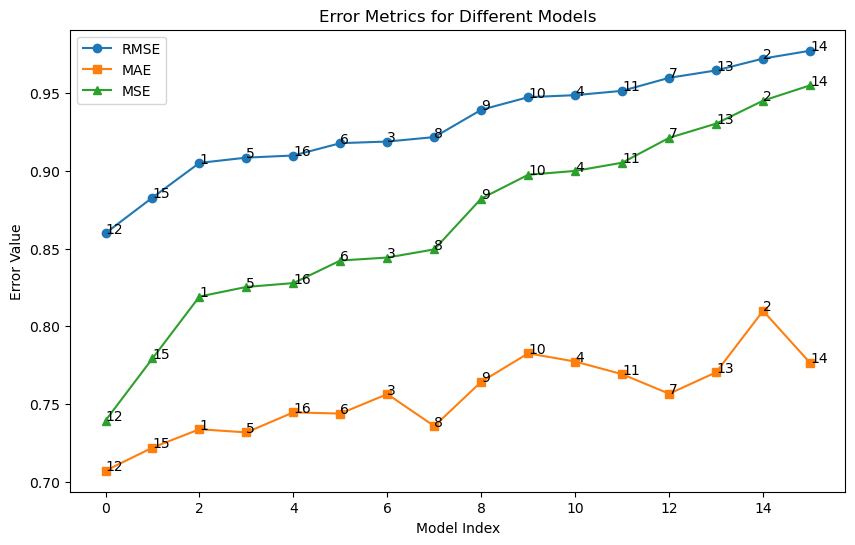

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

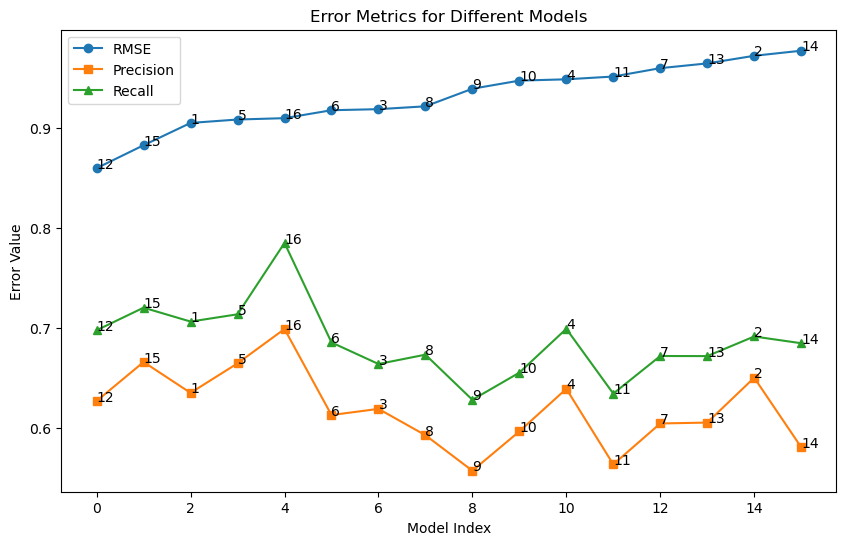

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

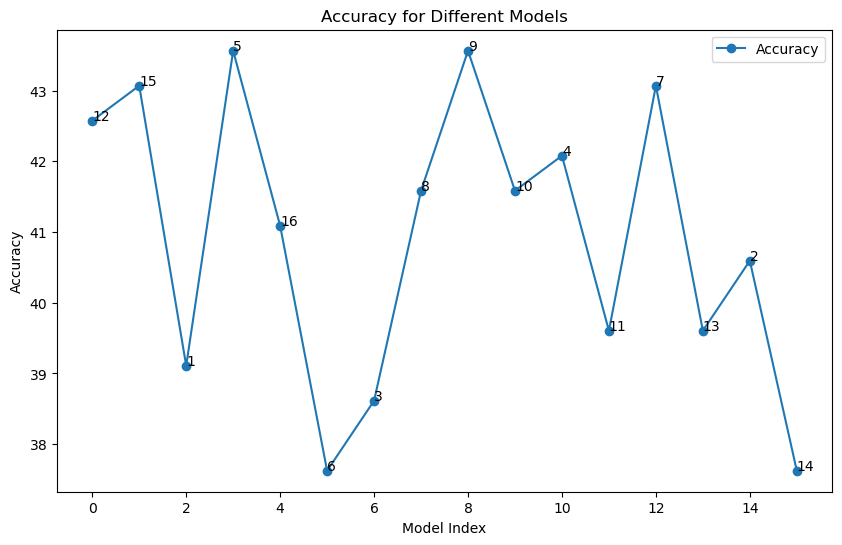

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 13 with sim 1.000000000000000
And the baseline estimate is: 4.926364117616144

#####

Note: If the baseline is 3.6325581395348836 then the value is a default value, Otherwise not


In [25]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,13016d41-00bd-411c-83f5-2b95691696b7,Chianti,2.0,3.567442,"{'was_impossible': True, 'reason': 'Not enough...",14,3,1.567442
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pinot grigio,2.0,2.167567,"{'actual_k': 32, 'was_impossible': False}",94,1,0.167567
2,5ccd8030-047b-432c-a630-d784ab415756,Rosé Sundreamer,4.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",84,1,0.432558
3,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 1,3.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",45,1,0.567442
4,87609866-dc17-4eb7-884f-b6bdfb80d20c,Rèmole Rosso,4.0,3.567442,"{'was_impossible': True, 'reason': 'Not enough...",0,0,0.432558
5,23b6603a-928c-4e54-9c34-bdf3dcb45435,Bardolino,4.0,3.567442,"{'was_impossible': True, 'reason': 'Not enough...",2,3,0.432558
6,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Poggio badiola,2.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",94,1,1.567442
7,bc79b0e3-064d-4240-86de-e86499f577e8,5/20 Domaine de Thalabert Croze Hermitage,3.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",45,1,0.567442
8,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Anjou Blanc,3.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",27,1,0.567442
9,00324bc3-0b35-4051-bc6d-9c258a4252c2,Ettore germano riesling,5.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.432558


* best predictions

In [26]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
148,5ccd8030-047b-432c-a630-d784ab415756,Randersacker Spätburgunder Rosé,3.0,3.000000,"{'actual_k': 5, 'was_impossible': False}",84,0,0.000000
71,c60f0ff1-ed30-4df6-a612-b9ae7ca0814b,Vitovska,3.0,3.000000,"{'actual_k': 2, 'was_impossible': False}",2,1,0.000000
134,13016d41-00bd-411c-83f5-2b95691696b7,Pinot Grigio,4.0,4.000000,"{'actual_k': 1, 'was_impossible': False}",14,6,0.000000
123,5ccd8030-047b-432c-a630-d784ab415756,Dettelbach Silvaner,3.0,3.000000,"{'actual_k': 5, 'was_impossible': False}",84,2,0.000000
58,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Cabernet Franc,3.0,3.012462,"{'actual_k': 4, 'was_impossible': False}",58,4,0.012462
45,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Bollicina,4.0,3.985443,"{'actual_k': 3, 'was_impossible': False}",7,3,0.014557
37,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Brunello di Montalcino,4.0,4.033621,"{'actual_k': 11, 'was_impossible': False}",94,2,0.033621
23,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Jesera Pinot Grigio,4.0,4.033621,"{'actual_k': 11, 'was_impossible': False}",94,1,0.033621
199,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il mattaglio brut,5.0,4.954914,"{'actual_k': 11, 'was_impossible': False}",94,1,0.045086
175,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il Mattaglio Blanc de Blancs,5.0,4.954914,"{'actual_k': 11, 'was_impossible': False}",94,2,0.045086


* worst predictions

In [27]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
92,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Valle Central Merlot,2.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",27,0,1.567442
171,5ccd8030-047b-432c-a630-d784ab415756,Blauer Wildbacher,2.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",84,1,1.567442
172,91cf68cc-9436-43e1-871d-33beef4d2337,Sacred Hill Pinot Noir,2.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",19,1,1.567442
108,5ccd8030-047b-432c-a630-d784ab415756,La Moneta Gavi,2.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",84,1,1.567442
0,13016d41-00bd-411c-83f5-2b95691696b7,Chianti,2.0,3.567442,"{'was_impossible': True, 'reason': 'Not enough...",14,3,1.567442
106,13016d41-00bd-411c-83f5-2b95691696b7,Terrano,2.0,4.000000,"{'actual_k': 3, 'was_impossible': False}",14,5,2.000000
165,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",45,1,2.567442
99,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",1,0,2.567442
126,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.567442
79,877019f9-3c77-491d-912e-58b2404aed47,Chianti,1.0,3.567442,"{'was_impossible': True, 'reason': 'User and/o...",1,3,2.567442
